In [190]:
import seaborn as sns 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from dataprep import eda 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid

In [2]:
epsilon=1e-8

In [3]:
train_no_out= pd.read_csv("data_no_outliers.csv")
x_train = train_no_out.drop(['smoking'],axis=1)
y_train = train_no_out['smoking']



test = pd.read_csv("test_data.csv")

val = pd.read_csv("validation_data.csv")


In [4]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101819 entries, 0 to 101818
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   weight(kg)              101819 non-null  int64  
 1   HDL                     101819 non-null  int64  
 2   LDL                     101819 non-null  int64  
 3   Cholesterol             101819 non-null  int64  
 4   hemoglobin              101819 non-null  float64
 5   eyesight(right)         101819 non-null  float64
 6   AST                     101819 non-null  int64  
 7   waist(cm)               101819 non-null  float64
 8   triglyceride            101819 non-null  int64  
 9   HDL-LDL Ratio           101819 non-null  float64
 10  HDL-triglyceride Ratio  101819 non-null  float64
 11  LDL-triglyceride Ratio  101819 non-null  float64
dtypes: float64(6), int64(6)
memory usage: 9.3 MB


In [5]:
test["HDL-LDL Ratio"] = test["HDL"] / test["LDL"]
test["HDL-triglyceride Ratio"] = test["HDL"] / test["triglyceride"]
test["LDL-triglyceride Ratio"] = test["LDL"] / test["triglyceride"]


In [6]:
val["HDL-LDL Ratio"] = val["HDL"] / val["LDL"]
val["HDL-triglyceride Ratio"] = val["HDL"] / val["triglyceride"]
val["LDL-triglyceride Ratio"] = val["LDL"] / val["triglyceride"]


In [7]:
test= test.drop(['hearing(left)'],axis=1)
val= val.drop(['hearing(left)'],axis=1)


In [8]:
x_test= test.drop(['smoking'],axis=1)
y_test = test['smoking']

x_val = val.drop(["smoking"],axis=1)
y_val = val['smoking']

In [9]:
skew_data = ["HDL",'LDL','eyesight(right)','AST','triglyceride'
           ,"HDL-LDL Ratio","HDL-triglyceride Ratio","LDL-triglyceride Ratio"]

norm_data = ["weight(kg)", "Cholesterol","hemoglobin","waist(cm)"]

In [10]:
x_train[skew_data] = np.log(x_train[skew_data])

In [11]:
x_test[skew_data] = np.log(x_test[skew_data])

In [12]:
x_val[skew_data] = np.log(x_val[skew_data])

In [13]:
s = StandardScaler()
x_train[norm_data]=s.fit_transform(x_train[norm_data])

In [14]:
x_test[norm_data]=s.transform(x_test[norm_data])

In [15]:
x_val[norm_data]=s.transform(x_val[norm_data])

In [114]:
class BaggedLogisticRegressionClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, num_of_bagged=20, base_model_params=None):
        self.num_of_bagged = num_of_bagged
        self.base_model_params = base_model_params if base_model_params else {'max_iter': 1000}
        self.models = [LogisticRegression(**self.base_model_params) for _ in range(num_of_bagged)]

    def fit(self, X, y):
        self.models = []  # Clear existing models

        for _ in range(self.num_of_bagged):
            indices = np.random.choice(len(X), size=len(X), replace=True)
            X_subset, y_subset = X.iloc[indices], y.iloc[indices]

            model = LogisticRegression(**self.base_model_params)
            model.fit(X_subset, y_subset)

            self.models.append(model)
    
    def predict(self, X):
        predictions = np.zeros((len(X), self.num_of_bagged))

        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict(X)

        avg_predictions = np.mean(predictions, axis=1)
        binary_predictions = (avg_predictions >= 0.5).astype(int)

        return binary_predictions
    
    def acc(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def get_params(self, deep=True):
        return {
            'num_of_bagged': self.num_of_bagged,
            'base_model_params': self.base_model_params,
        }

    def set_params(self, **params):
        if not params:
            return self

        for param, value in params.items():
            setattr(self, param, value)

        self.models = [LogisticRegression(**self.base_model_params) for _ in range(self.num_of_bagged)]  # Reset models
        return self

In [115]:
class BaggedDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, num_of_bagged=20, base_model_params=None):
        self.num_of_bagged = num_of_bagged
        self.base_model_params = base_model_params if base_model_params else {'max_depth': None}
        self.models = [DecisionTreeClassifier(**self.base_model_params) for _ in range(num_of_bagged)]

    def fit(self, X, y):
        self.models = []  # Clear existing models

        for _ in range(self.num_of_bagged):
            indices = np.random.choice(len(X), size=len(X), replace=True)
            X_subset, y_subset = X.iloc[indices], y.iloc[indices]

            model = DecisionTreeClassifier(**self.base_model_params)
            model.fit(X_subset, y_subset)

            self.models.append(model)
    
    def predict(self, X):
        predictions = np.zeros((len(X), self.num_of_bagged))

        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict(X)

        avg_predictions = np.mean(predictions, axis=1)
        binary_predictions = (avg_predictions >= 0.5).astype(int)

        return binary_predictions
    
    def acc(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def get_params(self, deep=True):
        return {
            'num_of_bagged': self.num_of_bagged,
            'base_model_params': self.base_model_params,
        }

    def set_params(self, **params):
        if not params:
            return self

        for param, value in params.items():
            setattr(self, param, value)

        self.models = [DecisionTreeClassifier(**self.base_model_params) for _ in range(self.num_of_bagged)]  # Reset models
        return self

In [116]:
bdtc=BaggedLogisticRegressionClassifier()

In [117]:
bdtc.fit(x_train,y_train)

In [118]:
y_pred=bdtc.predict(x_test)

In [119]:
bdtc.acc(y_test,y_pred)

0.7248409243134628

In [120]:
bdtc2=BaggedLogisticRegressionClassifier()

In [121]:
param_grid = {
    'n_estimators': [25, 30, 40,  50, 80, 100],
    'base_model_params': [{'max_depth': d} for d in [1, 2, 3]]
}

In [122]:
param_grid = {
    'n_estimators': [25, 30, 40,  50, 80, 100],
    'base_model_params': [0.01,0.001,0.1,0.0001]
}

In [123]:
grid_search = GridSearchCV(estimator=bdtc2, param_grid=param_grid, cv=3, scoring='accuracy')


In [124]:
bdtc2.fit(x_train, y_train)

In [125]:
y_pred=bdtc2.predict(x_test)

In [126]:
bdtc2.acc(y_test,y_pred)

0.724715338245144

In [127]:
bdtc3=BaggedLogisticRegressionClassifier()

In [128]:
random_search = RandomizedSearchCV(bdtc3, param_grid, cv=3, scoring="accuracy")


In [129]:
bdtc3.fit(x_train, y_train)

In [130]:
y_pred=bdtc3.predict(x_test)

In [131]:
bdtc3.acc(y_test,y_pred)

0.724715338245144

In [159]:
# Define the hyperparameter grid
grid_search_params = {
    'num_of_bagged': [10, 50, 100],
    'base_model_params': [{'max_iter': 1000}, {'max_iter': 2000}, {'max_iter': 500}]
}

best_accuracy = 0.0
best_params = {}

# Perform manual grid search
for num_of_bagged in grid_search_params['num_of_bagged']:
    for base_model_param in grid_search_params['base_model_params']:
        # Create and train the BaggedLogisticRegressionClassifier
        bagged_model = BaggedLogisticRegressionClassifier(num_of_bagged=num_of_bagged, base_model_params=base_model_param)
        bagged_model.fit(x_train, y_train)

        # Make predictions on the validation set
        predictions = bagged_model.predict(x_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, predictions)

        # Update best parameters if accuracy is higher
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'num_of_bagged': num_of_bagged, 'base_model_params': base_model_param}

print("Best Parameters from Grid Search:", best_params)
print("Best Accuracy from Grid Search:", best_accuracy)


Best Parameters from Grid Search: {'num_of_bagged': 10, 'base_model_params': {'max_iter': 2000}}
Best Accuracy from Grid Search: 0.7264012725522206


In [192]:
bagging_acc = 0.7264012725522206

### Boosting AdaBoost

In [145]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [146]:

class MyAdaBoost(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=5):
        self.n_estimators = n_estimators
        self.models = []
        self.alphas = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        w = np.full(n_samples, (1/n_samples))

        for _ in range(self.n_estimators):
            model = DecisionTreeClassifier(max_depth=1)
            model.fit(X, y, sample_weight=w)

            predictions = model.predict(X)

            error = np.sum(w * (predictions != y))
            alpha = 0.5 * np.log((1 - error) / max(error, 1e-10))

            w *= np.exp(-alpha * y * predictions)
            w /= np.sum(w)

            self.models.append(model)
            self.alphas.append(alpha)

    def predict(self, X):
        predictions = np.zeros(len(X))

        for model, alpha in zip(self.models, self.alphas):
            predictions += alpha * model.predict(X)
        return np.sign(predictions)

    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
        }

    def set_params(self, **params):
        if not params:
            return self

        for param, value in params.items():
            setattr(self, param, value)

        return self


In [147]:
clf = MyAdaBoost()
clf.fit(x_train, y_train)



In [148]:
y_pred = clf.predict(x_test)
acc = accuracy(y_test, y_pred)
print(acc)

0.6935699933020764


In [149]:
param_grid = {
    'n_estimators': [20, 30, 100, 150 , 200, 300]
}

In [150]:
clf2 = MyAdaBoost()
grid_search = GridSearchCV(estimator=clf2, param_grid=param_grid, cv=3, scoring='accuracy')


In [151]:
clf2.fit(x_train,y_train)

In [152]:
y_pred = clf2.predict(x_test)
acc = accuracy(y_test, y_pred)
print(acc)

0.6935699933020764


In [156]:
clf3 = MyAdaBoost()
grid_search = RandomizedSearchCV(estimator=clf3, param_distributions=param_grid, cv=3, scoring='accuracy')


In [157]:
y_pred = clf3.predict(x_test)
acc = accuracy(y_test, y_pred)
print(acc)

0.5592347622237106


In [162]:
# Define the hyperparameter grid
grid_search_params = {
    'n_estimators': [50, 100, 150,200],
}

best_accuracy = 0.0
best_params = {}

# Perform manual grid search
for n_estimators in grid_search_params['n_estimators']:
    # Create and train the MyAdaBoost classifier
    ada_boost_model = MyAdaBoost(n_estimators=n_estimators)
    ada_boost_model.fit(x_train, y_train)

    # Make predictions on the validation set
    predictions = ada_boost_model.predict(x_val)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, predictions)

    # Update best parameters if accuracy is higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'n_estimators': n_estimators}

print("Best Parameters from Grid Search:", best_params)
print("Best Accuracy from Grid Search:", best_accuracy)


Best Parameters from Grid Search: {'n_estimators': 50}
Best Accuracy from Grid Search: 0.6935409602746033


In [193]:
boosting_acc = 0.6935409602746033

### RandomForest

In [178]:
class MyRandomForest:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.models = []

    def fit(self, x, y):
        x = np.array(x)
        y = np.array(y)
        n_samples, n_features = x.shape
        for _ in range(self.n_estimators):
            selected_features = np.random.choice(n_features, size=int(np.sqrt(n_features)), replace=False)
            x_subset = x[:, selected_features]

            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf
            )
            tree.fit(x_subset, y)
            self.models.append((tree, selected_features))
        return self

    def predict(self, x):
        x = np.array(x)
        pred = np.zeros((x.shape[0], self.n_estimators))
        for i, (tree, selected_features) in enumerate(self.models):
            x_subset = x[:, selected_features]
            pred[:, i] = tree.predict(x_subset)

        # Use majority voting for the final prediction
        final_predictions = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=pred)
        return final_predictions
    
    def acc(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy

    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf
        }

    def set_params(self, **params):
        if not params:
            return self

        for param, value in params.items():
            setattr(self, param, value)

        return self

In [179]:

random_forest = MyRandomForest()
random_forest.fit(x_train, y_train)


In [181]:
y_pred= random_forest.predict(x_test)
rf_accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Accuracy: 0.7073425987943738


In [185]:
param_grid_random_forest = {
    'n_estimators': [50,100,200],
    'max_depth': [1, 5, 10]
}


In [186]:
randomForest_model = MyRandomForest()
randomForest_grid = GridSearchCV(estimator=randomForest_model, param_grid=param_grid_random_forest, cv=3, scoring='accuracy')
randomForest_grid.fit(x_train, y_train)
print("Best Parameters for Random Forest:", randomForest_grid.best_params_)
print('Best Score for Random Forest:', randomForest_grid.best_score_) 

Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 200}
Best Score for Random Forest: 0.710329181760922


In [188]:
randomForest_model2 = MyRandomForest()
randomForest_grid = RandomizedSearchCV(estimator=randomForest_model2, param_distributions=param_grid_random_forest, cv=3, scoring='accuracy')
randomForest_grid.fit(x_train, y_train)
print("Best Parameters for Random Forest:", randomForest_grid.best_params_)
print('Best Score for Random Forest:', randomForest_grid.best_score_) 

/home/hy/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for Random Forest: {'n_estimators': 100, 'max_depth': 5}
Best Score for Random Forest: 0.7098576461452625


In [191]:
param_grid_random_forest = {
    'n_estimators': [50,100,200],
    'max_depth': [1, 5, 10]
}

param_combinations = list(ParameterGrid(param_grid))


best_params = None
best_accuracy = 0.0

# Perform grid search
for params in param_combinations:

    rf_model = MyRandomForest(**params)
    rf_model.fit(x_train, y_train)
    

    predictions = rf_model.predict(x_val)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, predictions)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Best Accuracy: 0.7208338565867135


In [194]:
rf_acc = 0.7208338565867135

### Final System
comparing max accuracy i can get by each

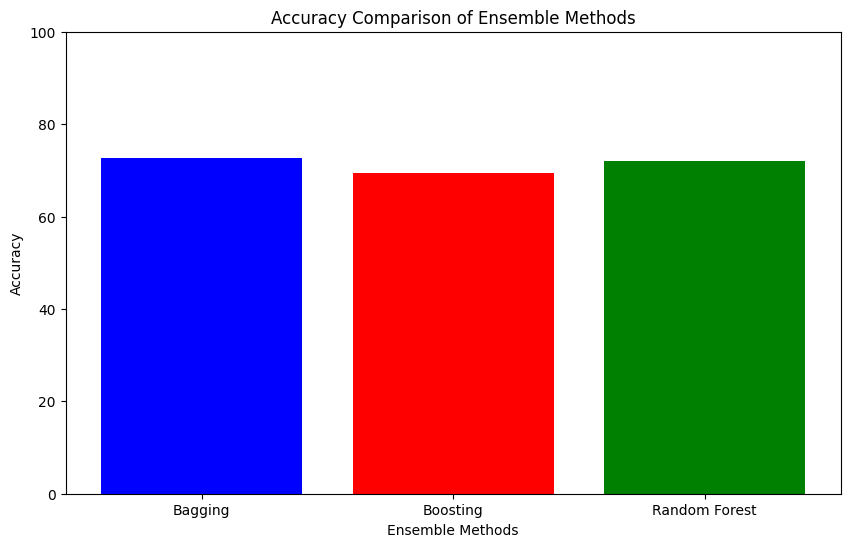

In [201]:
plt.figure(figsize=(10, 6))
methods = ['Bagging', 'Boosting', 'Random Forest']
accuracies = [bagging_acc*100, boosting_acc*100, rf_acc*100]

plt.bar(methods, accuracies, color=['blue', 'red', 'green'])
plt.xlabel('Ensemble Methods')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Ensemble Methods')
plt.ylim(0, 100)  # Set the y-axis limit between 0 and 100 for percentage accuracy values
plt.show()

The accuracies are very close to each other with bagging slightly higher than random forest and both higher than Adaboost